In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pickle
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import random
import itertools
import re
import torch.optim as optim
from scipy.stats import spearmanr
from transformers import AutoTokenizer, AutoModel

In [ ]:
class CrossAttnContrastive(nn.Module):
    def __init__(
        self,
        d_esm: int,
        d_emb: int,
        hidden_dims: list[int],
        contrast_type: str = "subtract",
        dropout_rate: float = 0.1,
    ):
        """
        Cross‐attention contrastive model.

        Args:
        -----
        d_esm: int
            Dimension of the input ESM embeddings (hidden size).
        d_emb: int
            Dimension of the key/value embeddings and query.
        hidden_dims: list[int]
            Hidden layer sizes for the final MLP.
        contrast_type: {"subtract","concat"}
            How to form the contrastive vector.
        dropout_rate: float
            Dropout probability in the final MLP.
        """
        super().__init__()
        assert contrast_type in ("subtract", "concat")
        self.contrast_type = contrast_type
        self.d_emb = d_emb

        # Cross‐attention parameters
        self.w_k = nn.Linear(d_esm, d_emb, bias=False)
        self.w_v = nn.Linear(d_esm, d_emb, bias=False)
        self.query = nn.Parameter(torch.randn(d_emb))

        # Final MLP:
        contrast_dim = d_emb if contrast_type == "subtract" else 2 * d_emb
        mlp_dims = [contrast_dim+1] + hidden_dims + [1]
        layers = []
        for i in range(len(mlp_dims) - 1):
            layers.append(nn.Linear(mlp_dims[i], mlp_dims[i+1]))
            if i < len(mlp_dims) - 2:
                layers.append(nn.ReLU(inplace=True))
                layers.append(nn.Dropout(dropout_rate))
        self.output_mlp = nn.Sequential(*layers)

    def forward(self, emb1, emb2, fit1) -> torch.Tensor:
        """
        emb1, emb2: (N, L, d_esm)
        fit1: (N, 1) fitness of the first variants
        Returns:
        --------
        logits: (N,) scalar predictions
        """
        N, L, _ = emb1.shape

        # -- Cross‐attention pooling for emb1 and emb2 --
        # Compute keys and values: (N, L, d_emb)
        K1 = self.w_k(emb1)
        V1 = self.w_v(emb1)
        K2 = self.w_k(emb2)
        V2 = self.w_v(emb2)

        # Prepare query: (1, d_emb) -> (N, 1, d_emb)
        Q = self.query.unsqueeze(0).unsqueeze(1).expand(N, 1, self.d_emb)

        # Scaled dot‐product attention scores: (N, 1, L)
        scale = math.sqrt(self.d_emb)
        attn1 = F.softmax((Q @ K1.transpose(1, 2)) / scale, dim=-1)
        attn2 = F.softmax((Q @ K2.transpose(1, 2)) / scale, dim=-1)

        # Weighted sum of values: (N, 1, d_emb) -> (N, d_emb)
        v1 = (attn1 @ V1).squeeze(1)
        v2 = (attn2 @ V2).squeeze(1)

        # -- Contrastive embedding --
        if self.contrast_type == "subtract":
            c = v2 - v1          # (N, d_emb)
        else:  # "concat"
            c = torch.cat([v1, v2], dim=1)  # (N, 2*d_emb)
        c = torch.cat([c, fit1], dim=1)

        # -- Final MLP to scalar logit --
        out = self.output_mlp(c).squeeze(1)  # (N,)
        return out

In [ ]:
def load_data(idx1, idx2, fit1, labels, emb, batch, batch_size, device):
    """
    Returns:
      emb1_batch: (B, L, d_esm) torch.Tensor
      emb2_batch: (B, L, d_esm) torch.Tensor
      fit1_batch: (B, 1)      torch.Tensor
      labels_batch:(B,)       torch.Tensor
    """
    start = batch * batch_size
    end   = min(start + batch_size, len(labels))
    b_idx1 = idx1[start:end]
    b_idx2 = idx2[start:end]
    b_fit1 = np.array(fit1[start:end], dtype=np.float32).reshape(-1,1)
    b_lbl  = np.array(labels[start:end], dtype=np.float32).reshape(-1,1)

    emb1 = emb[np.array(b_idx1)]
    emb2 = emb[np.array(b_idx2)]
    emb1 = torch.from_numpy(emb1).float().to(device)
    emb2 = torch.from_numpy(emb2).float().to(device)
    fit1 = torch.from_numpy(b_fit1).float().to(device)
    lbl  = torch.from_numpy(b_lbl).squeeze(1).float().to(device)
    return emb1, emb2, fit1, lbl


def train_epoch(model, optimizer, idx1, idx2, fit1, labels, emb, batch_size, epoch, device, train_frac):
    model.train()
    criterion = nn.MSELoss()
    running_loss = 0.0
    total = 0
    all_preds = []
    all_targets = []
    num_batches = math.ceil(len(labels) / batch_size)
    batch_set_size = math.ceil(num_batches/train_frac)
    batch_set_idx = (epoch-1)%train_frac
    start_b = batch_set_idx * batch_set_size
    end_b = (batch_set_idx+1) * batch_set_size
    for b in tqdm(list(range(num_batches))[start_b: end_b], desc=f"Epoch {epoch}"):
        e1, e2, f1, y = load_data(idx1, idx2, fit1, labels, emb, b, batch_size, device)
        preds = model(e1, e2, f1)
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * preds.size(0)
        total += preds.size(0)
        all_preds.append(preds.cpu())
        all_targets.append(y.cpu())
    all_preds = torch.cat(all_preds).detach().cpu().numpy()
    all_targets = torch.cat(all_targets).detach().cpu().numpy()
    corr, _ = spearmanr(all_preds, all_targets)
    return running_loss / total, corr


def test_epoch(model, idx1, idx2, fit1, labels, emb, batch_size, epoch, device, test_frac=None):
    model.eval()
    criterion = nn.MSELoss()
    running_loss = 0.0
    total = 0
    all_preds = []
    all_targets = []
    num_batches = math.ceil(len(labels) / batch_size)
    b_set = list(range(num_batches))
    if test_frac:
        b_set = random.sample(range(num_batches), math.ceil(num_batches/test_frac))
    with torch.no_grad():
        for b in tqdm(b_set, desc=f"Epoch {epoch}"):
            e1, e2, f1, y = load_data(idx1, idx2, fit1, labels, emb, b, batch_size, device)
            preds = model(e1, e2, f1)
            loss = criterion(preds, y)
            running_loss += loss.item() * preds.size(0)
            total += preds.size(0)
            all_preds.append(preds.cpu())
            all_targets.append(y.cpu())
    avg_loss = running_loss / total
    all_preds = torch.cat(all_preds).detach().cpu().numpy()
    all_targets = torch.cat(all_targets).detach().cpu().numpy()
    corr, _ = spearmanr(all_preds, all_targets)
    return avg_loss, corr, all_preds, all_targets

# Re-train the CrossAttnContrastive model on the entire dataset

Epoch 1: 100%|██████████| 11907/11907 [03:51<00:00, 51.35it/s]


Epoch   1 ▶ Train Loss 11.1975 | Spear 0.5413


Epoch 2: 100%|██████████| 11907/11907 [03:35<00:00, 55.15it/s]


Epoch   2 ▶ Train Loss 6.2801 | Spear 0.6539


Epoch 3: 100%|██████████| 11907/11907 [03:55<00:00, 50.50it/s]


Epoch   3 ▶ Train Loss 4.6559 | Spear 0.7050


Epoch 4: 100%|██████████| 11907/11907 [03:57<00:00, 50.20it/s]


Epoch   4 ▶ Train Loss 3.5672 | Spear 0.7124


Epoch 5: 100%|██████████| 11907/11907 [03:40<00:00, 54.03it/s]


Epoch   5 ▶ Train Loss 2.8831 | Spear 0.7410


Epoch 6: 100%|██████████| 11907/11907 [03:47<00:00, 52.30it/s]


Epoch   6 ▶ Train Loss 2.7666 | Spear 0.7521


Epoch 7: 100%|██████████| 11907/11907 [03:48<00:00, 52.04it/s]


Epoch   7 ▶ Train Loss 2.6709 | Spear 0.7618


Epoch 8: 100%|██████████| 11907/11907 [03:53<00:00, 50.97it/s]


Epoch   8 ▶ Train Loss 2.5935 | Spear 0.7700


Epoch 9: 100%|██████████| 11907/11907 [03:40<00:00, 53.90it/s]


Epoch   9 ▶ Train Loss 2.5201 | Spear 0.7774


Epoch 10: 100%|██████████| 11907/11907 [03:55<00:00, 50.57it/s]


Epoch  10 ▶ Train Loss 2.4437 | Spear 0.7864


Epoch 11: 100%|██████████| 11907/11907 [03:55<00:00, 50.61it/s]


Epoch  11 ▶ Train Loss 2.3623 | Spear 0.7924


Epoch 12: 100%|██████████| 11907/11907 [03:53<00:00, 51.00it/s]


Epoch  12 ▶ Train Loss 2.3138 | Spear 0.7983


Epoch 13: 100%|██████████| 11907/11907 [03:36<00:00, 54.94it/s]


Epoch  13 ▶ Train Loss 2.2473 | Spear 0.8047


Epoch 14: 100%|██████████| 11907/11907 [03:39<00:00, 54.30it/s]


Epoch  14 ▶ Train Loss 2.2069 | Spear 0.8071


Epoch 15: 100%|██████████| 11907/11907 [03:40<00:00, 53.97it/s]


Epoch  15 ▶ Train Loss 2.1359 | Spear 0.8146


Epoch 16: 100%|██████████| 11907/11907 [03:39<00:00, 54.23it/s]


Epoch  16 ▶ Train Loss 2.0975 | Spear 0.8192


Epoch 17: 100%|██████████| 11907/11907 [03:43<00:00, 53.19it/s]


Epoch  17 ▶ Train Loss 2.0512 | Spear 0.8242


Epoch 18: 100%|██████████| 11907/11907 [03:59<00:00, 49.81it/s]


Epoch  18 ▶ Train Loss 2.0185 | Spear 0.8276


Epoch 19: 100%|██████████| 11907/11907 [03:56<00:00, 50.25it/s]


Epoch  19 ▶ Train Loss 1.9737 | Spear 0.8307


Epoch 20: 100%|██████████| 11907/11907 [03:50<00:00, 51.76it/s]


Epoch  20 ▶ Train Loss 1.9366 | Spear 0.8345


Epoch 21: 100%|██████████| 11907/11907 [03:47<00:00, 52.30it/s]


Epoch  21 ▶ Train Loss 1.9069 | Spear 0.8366


Epoch 22: 100%|██████████| 11907/11907 [03:29<00:00, 56.90it/s]


Epoch  22 ▶ Train Loss 1.8444 | Spear 0.8416


Epoch 23: 100%|██████████| 11907/11907 [03:43<00:00, 53.29it/s]


Epoch  23 ▶ Train Loss 1.8302 | Spear 0.8435


Epoch 24: 100%|██████████| 11907/11907 [03:47<00:00, 52.42it/s]


Epoch  24 ▶ Train Loss 1.8044 | Spear 0.8449


Epoch 25: 100%|██████████| 11907/11907 [03:53<00:00, 50.95it/s]


Epoch  25 ▶ Train Loss 1.7893 | Spear 0.8475


Epoch 26: 100%|██████████| 11907/11907 [03:52<00:00, 51.29it/s]


Epoch  26 ▶ Train Loss 1.7600 | Spear 0.8505


Epoch 27: 100%|██████████| 11907/11907 [03:58<00:00, 49.89it/s]


Epoch  27 ▶ Train Loss 1.7261 | Spear 0.8527


Epoch 28: 100%|██████████| 11907/11907 [03:58<00:00, 49.99it/s]


Epoch  28 ▶ Train Loss 1.7085 | Spear 0.8546


Epoch 29: 100%|██████████| 11907/11907 [03:48<00:00, 52.05it/s]


Epoch  29 ▶ Train Loss 1.6741 | Spear 0.8570


Epoch 30: 100%|██████████| 11907/11907 [03:45<00:00, 52.74it/s]


Epoch  30 ▶ Train Loss 1.6674 | Spear 0.8577


Epoch 31: 100%|██████████| 11907/11907 [03:59<00:00, 49.71it/s]


Epoch  31 ▶ Train Loss 1.6398 | Spear 0.8609


Epoch 32: 100%|██████████| 11907/11907 [04:01<00:00, 49.34it/s]


Epoch  32 ▶ Train Loss 1.6360 | Spear 0.8624


Epoch 33: 100%|██████████| 11907/11907 [03:49<00:00, 51.88it/s]


Epoch  33 ▶ Train Loss 1.5995 | Spear 0.8654


Epoch 34: 100%|██████████| 11907/11907 [03:41<00:00, 53.77it/s]


Epoch  34 ▶ Train Loss 1.5764 | Spear 0.8668


Epoch 35: 100%|██████████| 11907/11907 [03:39<00:00, 54.26it/s]


Epoch  35 ▶ Train Loss 1.5766 | Spear 0.8683


Epoch 36: 100%|██████████| 11907/11907 [03:55<00:00, 50.53it/s]


Epoch  36 ▶ Train Loss 1.5515 | Spear 0.8694


Epoch 37: 100%|██████████| 11907/11907 [03:56<00:00, 50.31it/s]


Epoch  37 ▶ Train Loss 1.5187 | Spear 0.8713


Epoch 38: 100%|██████████| 11907/11907 [03:42<00:00, 53.40it/s]


Epoch  38 ▶ Train Loss 1.5096 | Spear 0.8718


Epoch 39: 100%|██████████| 11907/11907 [03:34<00:00, 55.45it/s]


Epoch  39 ▶ Train Loss 1.4813 | Spear 0.8749


Epoch 40: 100%|██████████| 11907/11907 [03:51<00:00, 51.38it/s]


Epoch  40 ▶ Train Loss 1.4928 | Spear 0.8750


Epoch 41: 100%|██████████| 11907/11907 [03:47<00:00, 52.33it/s]


Epoch  41 ▶ Train Loss 1.4683 | Spear 0.8767


Epoch 42: 100%|██████████| 11907/11907 [03:48<00:00, 52.08it/s]


Epoch  42 ▶ Train Loss 1.4496 | Spear 0.8783


Epoch 43: 100%|██████████| 11907/11907 [03:39<00:00, 54.18it/s]


Epoch  43 ▶ Train Loss 1.4285 | Spear 0.8793


Epoch 44: 100%|██████████| 11907/11907 [03:47<00:00, 52.23it/s]


Epoch  44 ▶ Train Loss 1.4186 | Spear 0.8800


Epoch 45: 100%|██████████| 11907/11907 [03:42<00:00, 53.40it/s]


Epoch  45 ▶ Train Loss 1.4101 | Spear 0.8814


Epoch 46: 100%|██████████| 11907/11907 [04:00<00:00, 49.42it/s]


Epoch  46 ▶ Train Loss 1.3911 | Spear 0.8828


Epoch 47: 100%|██████████| 11907/11907 [03:54<00:00, 50.68it/s]


Epoch  47 ▶ Train Loss 1.3802 | Spear 0.8840


Epoch 48: 100%|██████████| 11907/11907 [03:55<00:00, 50.58it/s]


Epoch  48 ▶ Train Loss 1.3720 | Spear 0.8849


Epoch 49: 100%|██████████| 11907/11907 [03:50<00:00, 51.56it/s]


Epoch  49 ▶ Train Loss 1.3463 | Spear 0.8866


Epoch 50: 100%|██████████| 11875/11875 [03:44<00:00, 52.82it/s]


Epoch  50 ▶ Train Loss 1.3402 | Spear 0.8879


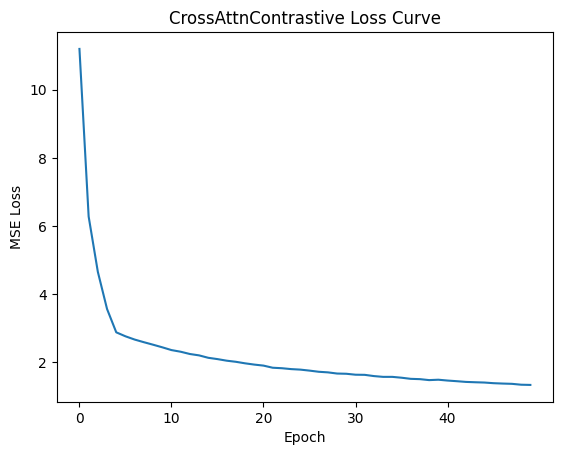

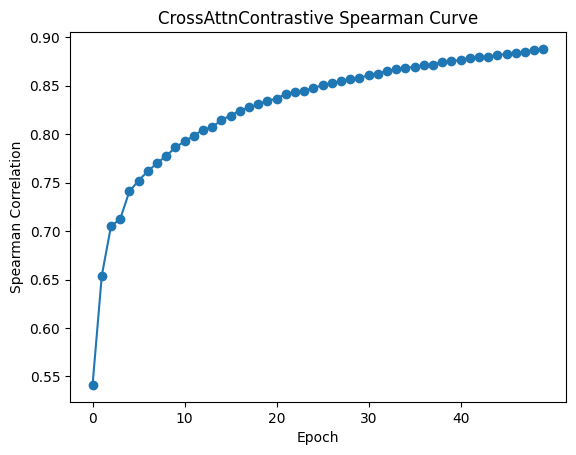

In [ ]:
# Define hyperparameters and instantiate model
batch_size    = 16
train_frac    = 50                 # fraction of training batches to include in each epoch
n_epoch       = train_frac
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CrossAttnContrastive(
    d_esm=1280,
    d_emb=320,
    hidden_dims=[160],
    contrast_type='subtract',
    dropout_rate=0.1
).to(device)
optimizer = optim.Adam(model.parameters(), lr=4e-6, weight_decay=1e-4)


# --- load & preprocess data ---
n_round = 3
train_idx1, train_idx2, train_fit1, train_lbl = [], [], [], []

emb_list = []
offset = 0
for r in [f'r{i}' for i in range(1, n_round+1)]:
    emb = np.load(f'/content/drive/MyDrive/Mid_1_data_train/ESM_emb_{r}.npy')
    emb_list.append(emb)
    seq2idx = pickle.load(open(f'/content/drive/MyDrive/Mid_1_data_train/seq_to_index_{r}.pkl','rb'))
    df_tr = pd.read_csv(f'/content/drive/MyDrive/Mid_1_data_train/data_contrastive_inference_{r}.csv').sample(frac=1, random_state=1).reset_index(drop=True)

    train_idx1 += [seq2idx[s.rstrip('*')]+offset for s in df_tr['seq_1']]
    train_idx2 += [seq2idx[s.rstrip('*')]+offset for s in df_tr['seq_2']]
    train_fit1 += [float(f) for f in df_tr['fitness_1']]
    train_lbl  += [float(y) for y in df_tr['label']]

    offset += emb.shape[0]
emb = np.concatenate(emb_list)



# --- training loop ---

train_losses = []
train_spears  = []

for epoch in range(1, n_epoch+1):
    tr_loss, tr_corr = train_epoch(model, optimizer,
        train_idx1, train_idx2,
        train_fit1, train_lbl,
        emb, batch_size, epoch, device, train_frac)
    train_losses.append(tr_loss)
    train_spears.append(tr_corr)

    print(f"Epoch {epoch:3d} ▶ Train Loss {tr_loss:.4f} | Spear {tr_corr:.4f}")

torch.save(model.state_dict(), "/content/drive/MyDrive/Mid_1_Contrast_results/CrossAttnContrastive_inference.pt")



# --- plot loss & Spearman curves ---
epochs = range(len(train_losses))
ticks  = np.arange(0, len(train_losses), 10)

plt.figure()
plt.plot(epochs, train_losses)
plt.xticks(ticks)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title(f"CrossAttnContrastive Loss Curve")
plt.savefig("/content/drive/MyDrive/Mid_1_Contrast_results/CrossAttnContrastive_loss_inference.png")

plt.figure()
plt.plot(epochs, train_spears, marker='o')
plt.xticks(ticks)
plt.xlabel("Epoch")
plt.ylabel("Spearman Correlation")
plt.title(f"CrossAttnContrastive Spearman Curve")
plt.savefig("/content/drive/MyDrive/Mid_1_Contrast_results/CrossAttnContrastive_spearman_inference.png")
plt.show()

# Inference on point mutations

In [ ]:
# 1) Load model
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CrossAttnContrastive(
    d_esm=1280,
    d_emb=320,
    hidden_dims=[160],
    contrast_type='subtract',
    dropout_rate=0.1
).to(device)
checkpoint = "/content/drive/MyDrive/Mid_1_Contrast_results/CrossAttnContrastive_inference.pt"
model.load_state_dict(torch.load(checkpoint, map_location=device))
model.eval()

# 2) Prepare ESM-2 for embedding
esm_model_name = "facebook/esm2_t33_650M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(esm_model_name, do_lower_case=False)
esm = AutoModel.from_pretrained(esm_model_name).to(device)
esm.eval()

# 3) Build all point‐mutants of mid13sc
ref_seq = "MAGSDSPLAEQIKNTLTFIGQANAAGRMDEVRTLQKNLHPLWAEYFQLTEGSGGSPLAQQIQNGHVLIHQARAAGRMDEVRRLTEKTLQLMKEYFQQSD"
aas = list("ACDEFGHIKLMNPQRSTVWY")

variants = []
mutations = []
L = len(ref_seq)
for i, wt in enumerate(ref_seq):
    for aa in aas:
        if aa == wt:
            continue
        var = ref_seq[:i] + aa + ref_seq[i+1:]
        variants.append(var)
        mutations.append(f"{wt}{i+1}{aa}")

# include the wild‐type itself
variants.insert(0, ref_seq)
mutations.insert(0, "")

# 4) Embed mid13sc once (padded/truncated to length 101 tokens)
max_len = 101
with torch.no_grad():
    mid_toks = tokenizer(
        ref_seq,
        return_tensors="pt",
        padding="max_length",
        max_length=max_len,
        truncation=True,
        add_special_tokens=True
    ).to(device)
    mid_emb = esm(**mid_toks).last_hidden_state.squeeze(0)  # (101,1280)

# 5) Batch‐infer all variants
batch_size = 32
fit1_value = 8.666429599066408
results = []

for start in tqdm(range(0, len(variants), batch_size), desc="Inferring variants"):
    end = min(start + batch_size, len(variants))
    batch_seqs = variants[start:end]
    batch_muts = mutations[start:end]

    # tokenize & embed variants
    with torch.no_grad():
        toks = tokenizer(
            batch_seqs,
            return_tensors="pt",
            padding="max_length",
            max_length=max_len,
            truncation=True,
            add_special_tokens=True
        ).to(device)
        var_emb = esm(**toks).last_hidden_state       # (B, 101, 1280)

    # prepare emb1 = repeated mid_emb
    B = end - start
    emb1 = mid_emb.unsqueeze(0).repeat(B, 1, 1)       # (B, 101, 1280)
    emb2 = var_emb                                    # (B, 101, 1280)
    fit1 = torch.full((B, 1), fit1_value, device=device)  # (B,1)

    # predict
    with torch.no_grad():
        preds = model(emb1, emb2, fit1)               # (B,)

    for seq, mut, score in zip(batch_seqs, batch_muts, preds.cpu().numpy()):
        results.append({
            "sequence": seq,
            "mutation": mut,
            "predicted_improvement": score
        })

# 6) Rank & save
df_out = pd.DataFrame(results)
df_out = df_out.sort_values(
    "predicted_improvement",
    ascending=False
).reset_index(drop=True)

out_csv = "/content/drive/MyDrive/Mid_1_Contrast_results/mid13sc_point_mut_results.csv"
df_out.to_csv(out_csv, index=False)
print(f"Saved {len(df_out)} variants to {out_csv}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Inferring variants: 100%|██████████| 59/59 [03:45<00:00,  3.82s/it]

Saved 1882 variants to /content/drive/MyDrive/Mid_1_Contrast_results/mid13sc_point_mut_results.csv


# Find where the reference sequence is ranked

In [ ]:
df_out[df_out['mutation'] == '']

,sequence,mutation,predicted_improvement
471,MAGSDSPLAEQIKNTLTFIGQANAAGRMDEVRTLQKNLHPLWAEYF...,,-5.209373


# Inference on double/ triple mutations

In [ ]:
# 1) Load the previous single‐mutant results and pick top 30 (excluding wildtype)
df_single = pd.read_csv(
    "/content/drive/MyDrive/Mid_1_Contrast_results/mid13sc_point_mut_results.csv"
)
# exclude the wild‐type entry which has empty mutation string
df_filtered = df_single[df_single['mutation'] != ""].reset_index(drop=True)
top30 = df_filtered.head(30)
mut_list = top30['mutation'].tolist()

# 2) Generate all doublet & triplet combinations (only if positions differ)
#    parse mutation strings like "M1D" → (ref_aa, pos, alt_aa)
mut_pattern = re.compile(r'^([A-Z])(\d+)([A-Z])$')

def parse_mut(mut_str):
    m = mut_pattern.match(mut_str)
    return (int(m.group(2)) - 1, m.group(3))  # zero‐based pos, new AA

# Pre‐parse to tuples for fast checks
parsed = [parse_mut(m) for m in mut_list]
# Keep track of original mutation strings in same order
mutation_to_parsed = dict(zip(mut_list, parsed))

# Build valid combos
doublets = [
    combo for combo in itertools.combinations(mut_list, 2)
    if mutation_to_parsed[combo[0]][0] != mutation_to_parsed[combo[1]][0]
]
triplets = [
    combo for combo in itertools.combinations(mut_list, 3)
    if len({mutation_to_parsed[m][0] for m in combo}) == 3
]
all_combos = doublets + triplets

# 3) Apply mutations to the reference sequence
ref_seq = "MAGSDSPLAEQIKNTLTFIGQANAAGRMDEVRTLQKNLHPLWAEYFQLTEGSGGSPLAQQIQNGHVLIHQARAAGRMDEVRRLTEKTLQLMKEYFQQSD"

def apply_mutations(ref, muts):
    arr = list(ref)
    for mut in muts:
        pos, new_aa = mutation_to_parsed[mut]
        arr[pos] = new_aa
    return "".join(arr)

variants   = [apply_mutations(ref_seq, combo) for combo in all_combos]
mut_strs   = [",".join(combo) for combo in all_combos]

# 4) Load model & ESM embedder (assumes you ran the prior snippet)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Re‐load CrossAttnContrastive
model = CrossAttnContrastive(
    d_esm=1280,
    d_emb=320,
    hidden_dims=[160],
    contrast_type='subtract',
    dropout_rate=0.1
).to(device)
model.load_state_dict(torch.load(
    "/content/drive/MyDrive/Mid_1_Contrast_results/CrossAttnContrastive_inference.pt",
    map_location=device
))
model.eval()

# Re‐load ESM-2
from transformers import AutoTokenizer, AutoModel
esm_name = "facebook/esm2_t33_650M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(esm_name, do_lower_case=False)
esm = AutoModel.from_pretrained(esm_name).to(device)
esm.eval()

# Pre‐embed the reference once
max_len = 101
with torch.no_grad():
    tok = tokenizer(
        ref_seq,
        return_tensors="pt",
        padding="max_length",
        max_length=max_len,
        truncation=True,
        add_special_tokens=True
    ).to(device)
    ref_emb = esm(**tok).last_hidden_state.squeeze(0)  # (101,1280)

# 5) Batch‐embed & predict all combos
batch_size = 32
fit1_value = 8.666429599066408
results = []

for i in tqdm(range(0, len(variants), batch_size), desc="Doublet/Triplet inference"):
    batch_seqs = variants[i:i+batch_size]
    batch_muts = mut_strs[i:i+batch_size]
    B = len(batch_seqs)

    # Tokenize + embed
    with torch.no_grad():
        toks = tokenizer(
            batch_seqs,
            return_tensors="pt",
            padding="max_length",
            max_length=max_len,
            truncation=True,
            add_special_tokens=True
        ).to(device)
        var_emb = esm(**toks).last_hidden_state  # (B,101,1280)

    # Prepare emb1, emb2, fit1
    emb1 = ref_emb.unsqueeze(0).repeat(B,1,1)         # (B,101,1280)
    emb2 = var_emb                                    # (B,101,1280)
    fit1 = torch.full((B,1), fit1_value, device=device)

    # Predict
    with torch.no_grad():
        preds = model(emb1, emb2, fit1).cpu().numpy()  # (B,)

    # Collect
    for seq, muts, score in zip(batch_seqs, batch_muts, preds):
        results.append({
            "sequence": seq,
            "mutations": muts,
            "predicted_improvement": score
        })

# 6) Rank & save
df_out = pd.DataFrame(results)
df_out = df_out.sort_values(
    "predicted_improvement",
    ascending=False
).reset_index(drop=True)

out_csv = "/content/drive/MyDrive/Mid_1_Contrast_results/mid13sc_doublet_triplet_results.csv"
df_out.to_csv(out_csv, index=False)
print(f"Saved {len(df_out)} combined variants to {out_csv}")

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Doublet/Triplet inference: 100%|██████████| 102/102 [05:11<00:00,  3.05s/it]

Saved 3234 combined variants to /content/drive/MyDrive/Mid_1_Contrast_results/mid13sc_doublet_triplet_results.csv


# Change indexing (-4)

In [ ]:
import pandas as pd
import re

def adjust_single_mutation(mut_str: str) -> str:
    """
    Given a single‐mutation string like "M13V", subtract 4 from the integer part.
    E.g. "M13V" → "M9V".
    """
    pattern = re.compile(r'^([A-Z])(\d+)([A-Z])$')
    m = pattern.match(mut_str)
    if not m:
        return mut_str  # leave as is if it doesn't match
    aa1, num, aa2 = m.group(1), int(m.group(2)), m.group(3)
    new_num = num - 4
    return f"{aa1}{new_num}{aa2}"

def adjust_multiple_mutations(muts_str: str) -> str:
    """
    Given a comma‐separated list like "M5B,L8V,F21R", subtract 4 from every integer part:
    "M5B"→"M1B", "L8V"→"L4V", "F21R"→"F17R", etc.
    """
    # Replace every occurrence of Letter + Digits + Letter
    def repl(m):
        aa1, num, aa2 = m.group(1), int(m.group(2)), m.group(3)
        new_num = num - 4
        return f"{aa1}{new_num}{aa2}"

    pattern = re.compile(r'([A-Z])(\d+)([A-Z])')
    return pattern.sub(repl, muts_str)

# 1) Adjust the single‐mutation CSV
path_point = "/content/drive/MyDrive/Mid_1_Contrast_results/mid13sc_point_mut_results.csv"
df_point = pd.read_csv(path_point)

# Apply to the 'mutation' column
df_point['mutation'] = df_point['mutation'].astype(str).apply(adjust_single_mutation)

# Save back (overwrite)
df_point.to_csv(path_point, index=False)
print(f"Updated single‐mutation CSV saved to: {path_point}")

# 2) Adjust the doublet/triplet CSV
path_doublet = "/content/drive/MyDrive/Mid_1_Contrast_results/mid13sc_doublet_triplet_results.csv"
df_doublet = pd.read_csv(path_doublet)

# Apply to the 'mutations' column
df_doublet['mutations'] = df_doublet['mutations'].astype(str).apply(adjust_multiple_mutations)

# Save back (overwrite)
df_doublet.to_csv(path_doublet, index=False)
print(f"Updated doublet/triplet CSV saved to: {path_doublet}")

Updated single‐mutation CSV saved to: /content/drive/MyDrive/Mid_1_Contrast_results/mid13sc_point_mut_results.csv
Updated doublet/triplet CSV saved to: /content/drive/MyDrive/Mid_1_Contrast_results/mid13sc_doublet_triplet_results.csv
